# DiffEdit Implementation
by John Robinson

This notebook implements the paper, ["DIFFEDIT: DIFFUSION-BASED SEMANTIC IMAGE EDITING WITH MASK GUIDANCE".](https://arxiv.org/abs/2210.11427#)

[<img src="https://www.storminthecastle.com/img/github.svg">](https://github.com/johnrobinsn/diffusion_experiments/blob/main/DiffEdit.ipynb) [<img src="https://www.storminthecastle.com/img/colab.svg">](https://colab.research.google.com/github/johnrobinsn/diffusion_experiments/blob/main/DiffEdit.ipynb)

**Warning you'll need GPU acceleration.  Don't forget to enable if you use on Colab.**

Diffusion models have revolutionized the space of generative models for many domains, but most notably for image generation.  Not only can you generate amazing images given a random seed and a text prompt to guide the diffusion.  But you can also "edit" or modify the images in a targeted way using inpainting techniques.  Most of these inpainting techniques require a binarized mask to isolate changes and while generating these masks is straightforward it can be quite labor intensive to create them.  

This paper describes an approach of generating a prompt-directed mask using the same diffusion model used to generate and inpaint the images, thereby leveraging the investment already made in training the diffusion model (ie Stable Diffusion in this case.)  The DiffEdit algorithm takes as input an image and two prompts.  The first prompt, reference prompt, describes the object currently present in the image to be "removed" or edited out.  The second prompt, query prompt, describes the object that should take its place within the image.  These two prompts are used to derive a binarized mask that can be used to inpaint (or "paint in") what is described by the query prompt.

eg. "A Bowl of Strawberries" => "A Bowl of Oranges"

![DiffEdit Image](https://www.storminthecastle.com/img/diffedit.png)

Stable Diffusion works by adding random gaussian noise to an image and iteratively across some number of timesteps uses a neural network to predict the amount of noise to remove from the noised image, eventually arriving at an image that has all of the noise removed.  Since this is a stochastic process the image that we end up with won't necessarily be anything close to the image we started off with.  This noise removal process can also be guided by a text prompt which will steer the denoising process.   

DiffEdit leverages this denoising behavior to predict noise for both the reference prompt and the query prompt.  With the observation that given the same random seed that the noise for areas of the image not being guided by the prompt will be very similar, whilst the predicted noise in areas being actively guided by the prompts will differ much more (different textures/colors etc).  We can basically do a localized distance calculation to establish which areas should be modified based on comparing these noise values.

One detail that probably enables DiffEdit is that Stable Diffusion utilizes a [Variational Auto Encoder (VAE)](https://en.wikipedia.org/wiki/Variational_autoencoder) to compress the images into a latent representation.  This has several benefits. One being that the input image dimensions of 512 by 512 (3 channel) pixels is compressed down to a (1,4,64,64) shaped tensor called a latent.  The means that the model has to deal with a much smaller amount of data, which makes the model much more efficient and practical.  But with respect to the DiffEdit algorithm, each 4-channel "pixel" of the latent representation encodes not only color data but also encodes textures spatially (8x8 patch).  This greatly improves the contrast when the differencing operation is performed.

Continue on with this notebook to see my implementation and some demos of it in action.

Many thanks to the authors of the paper for their ideas and inspiration.

Also Special Thanks to [Jeremy Howard](https://twitter.com/jeremyphoward) for all of his great tips and techniques for reading and understanding academic papers that he shared in his [From Deep Learning Foundations to Stable Diffusion Course](https://www.fast.ai/posts/part2-2022.html)

Please follow me on Twitter, [@johnrobinsn](https://twitter.com/johnrobinsn) or on my blog, [https://www.storminthecastle.com](https://www.storminthecastle.com).


## Setup

### Install Dependencies

In [5]:

!pip3 install numpy
!pip3 install matplotlib
!pip3 install fastai
!pip3 install accelerate
!pip3 install --upgrade transformers diffusers ftfy

### Imports and Setup

In [ ]:
!pip3 install cv

In [ ]:
import os
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from fastcore.all import concat
from fastai.basics import show_image,show_images
from fastdownload import FastDownload
from pathlib import Path

from PIL import Image
import torch, logging
from torch import autocast
from torchvision import transforms as tfms

from huggingface_hub import notebook_login
from transformers import CLIPTextModel,CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL,UNet2DConditionModel,LMSDiscreteScheduler,StableDiffusionInpaintPipeline

import cv2

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# summarize tensor
_s = lambda x: (x.shape,x.max(),x.min())

/home/nitzanba/miniconda3/envs/diff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Authenticate with Hugging Face

To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. The [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) provides more details. If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* Use the `huggingface-cli login` command-line tool in your terminal and paste your token when prompted. It will be saved in a file in your computer.
* Or use `notebook_login()` in a notebook, which does the same thing.

In [ ]:
# torch.manual_seed(1)
# if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

ImportError: The `notebook_login` function can only be used in a notebook (Jupyter or Colab) and you need the `ipywidgets` module: `pip install ipywidgets`.

## Load Pretrained Hugging Face Models

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
# hyper parameters match those used during training the model
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);
vae_magic = 0.18215 # vae model trained with a scale term to get closer to unit variance

# Load RunwayML's Inpainting Model
inpaint = StableDiffusionInpaintPipeline.from_pretrained('runwayml/stable-diffusion-inpainting',revision="fp16",torch_dtype=torch.float16).to(torch_device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:270: FutureWarning: You are loading the variant fp16 from runwayml/stable-diffusion-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
safety_checker/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/821 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.75k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/810 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


## Utility Functions to Convert between Latents and Images

In [ ]:
def image2latent(im):
    im = tfms.ToTensor()(im).unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(im.to(torch_device)*2-1);
    latent = latent.latent_dist.sample() * vae_magic
    return latent

def latents2images(latents):
    latents = latents/vae_magic
    with torch.no_grad():
        imgs = vae.decode(latents).sample
    imgs = (imgs / 2 + 0.5).clamp(0,1)
    imgs = imgs.detach().cpu().permute(0,2,3,1).numpy()
    imgs = (imgs * 255).round().astype("uint8")
    imgs = [Image.fromarray(i) for i in imgs]
    return imgs

def get_embedding_for_prompt(prompt):
    max_length = tokenizer.model_max_length
    tokens = tokenizer([prompt],padding="max_length",max_length=max_length,truncation=True,return_tensors="pt")
    with torch.no_grad():
        embeddings = text_encoder(tokens.input_ids.to(torch_device))[0]
    return embeddings

## DiffEdit Implementation

In [ ]:
# Given a starting image latent and a prompt; predict the noise that should be removed to transform
# the noised source image to a denoised image guided by the prompt.
def predict_noise(text_embeddings,im_latents,seed=torch.seed(),guidance_scale=7,strength=0.5,**kwargs):
    num_inference_steps = 50            # Number of denoising steps

    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise

    uncond = get_embedding_for_prompt('')
    text_embeddings = torch.cat([uncond, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    offset = scheduler.config.get("steps_offset", 0)
    init_timestep = int(num_inference_steps * strength) + offset
    init_timestep = min(init_timestep, num_inference_steps)

    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps] * 1 * 1, device=torch_device)

    start_step = init_timestep
    noise = torch.randn_like(im_latents)
    latents = scheduler.add_noise(im_latents,noise,timesteps=timesteps)
    latents = latents.to(torch_device).float()

    t_start = max(num_inference_steps - init_timestep + offset, 0)
    timesteps = scheduler.timesteps[t_start:].to(torch_device)

    noisy_latent = latents.clone()

    noise_pred = None
    for i, tm in enumerate(timesteps):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, tm)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, tm, encoder_hidden_states=text_embeddings)["sample"]

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

        u = noise_pred_uncond
        g = guidance_scale
        t = noise_pred_text

        # perform guidance
        noise_pred = u + g * (t - u)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, tm, latents).prev_sample

    return latents2images(latents)[0],noise_pred

In [ ]:
# For a given reference prompt and a query prompt;
# Run the diffusion process 10 times; Calculating a "noise distance" for each sample
def calc_diffedit_samples(encoded,prompt1,prompt2,n=10,**kwargs):
    diffs=[]
    # So we can reproduce mask generation we generate a list of n seeds
    torch.manual_seed(torch.seed() if 'seed' not in kwargs else kwargs['seed'])
    seeds = torch.randint(0,2**62,(10,)).tolist()
    for i in range(n):
        kwargs['seed'] = seeds[i] # Important to use same seed for the two noise samples
        emb1 = get_embedding_for_prompt(prompt1)
        _im1,n1 = predict_noise(emb1,encoded,**kwargs)
        emb2 = get_embedding_for_prompt(prompt2)
        _im2,n2 = predict_noise(emb2,encoded,**kwargs)

        # Aggregate the channel components by taking the euclidean distance.
        diffs.append((n1-n2)[0].pow(2).sum(dim=0).pow(0.5)[None])
    all_masks = torch.cat(diffs)
    return all_masks

# Given an image latent and two prompts; generate a grayscale diff by sampling the noise predictions
# between the prompts.
def calc_diffedit_diff(im_latent,p1,p2,**kwargs):
    m = calc_diffedit_samples(im_latent,p1,p2,**kwargs)
    m = m.mean(axis=0) # average samples together
    m = (m-m.min())/(m.max()-m.min()) # rescale to interval [0,1]
    m = (m*255.).cpu().numpy().astype(np.uint8)
    m = Image.fromarray(m)
    return m

# Try to improve the mask thru convolutions etc
# assume m is a PIL object containing a grayscale 'diff'
def process_diffedit_mask(m,threshold=0.35,**kwargs):
    m = np.array(m).astype(np.float32)
    m = cv2.GaussianBlur(m,(5,5),1)
    m = (m>(255.*threshold)).astype(np.float32)*255
    m = Image.fromarray(m.astype(np.uint8))
    return m

# Given an image latent and two prompts; generate a binarized mask (PIL) appropriate for inpainting
def calc_diffedit_mask(im_latent,p1,p2,**kwargs):
    m = calc_diffedit_diff(im_latent,p1,p2,**kwargs)
    m = process_diffedit_mask(m,**kwargs)
    m = m.resize((512,512))
    return m

In [ ]:
# Composite the mask over the provided image; for demonstration purposes
def get_blended_mask(im,mask_gray): # Both expected to be PIL images
    mask_rgb = mask_gray.convert('RGB')
    return Image.blend(im,mask_rgb,0.40)

# Show the original image, the original image with mask and the resulting inpainted image
def demo_diffedit(im_path,p1,p2,**kwargs):
    im_path = Path(im_path)
    out = []

    im = Image.open(im_path).resize((512,512))
    im_latent = image2latent(im)
    out.append(im)

    if 'seed' not in kwargs: kwargs['seed'] = torch.seed()
    mask = calc_diffedit_mask(im_latent,p1,p2,**kwargs)
    out.append(get_blended_mask(im,mask))
    out.append(inpaint(prompt=[p2],image=im,mask_image=mask,
        generator=torch.Generator(torch_device).manual_seed(kwargs['seed'])).images[0])
    show_images(out)

## Demonstrate Mask Generation

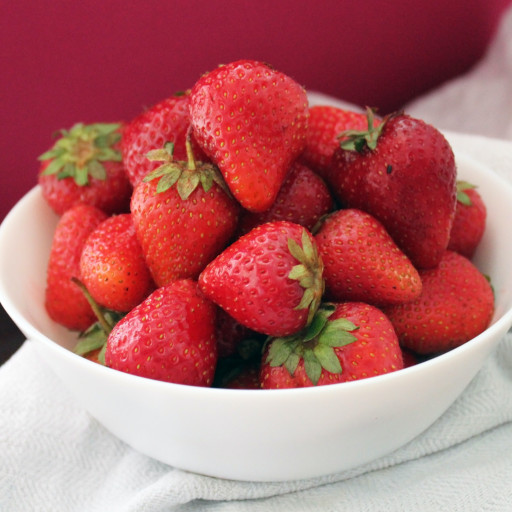

In [ ]:
#Load an image
p = FastDownload().download('https://raw.githubusercontent.com/johnrobinsn/diffusion_experiments/main/images/bowloberries_scaled.jpg')
im = Image.open(p).resize((512,512));im

In [ ]:
# We operate in latent space
latent = image2latent(im); latent.shape

torch.Size([1, 4, 64, 64])

seed: 12765083811071779585


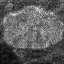

In [ ]:
# !! This will take at least a few minutes.  The mask generation algorithm described in the DiffEdit paper !!
# !! requires that we run the stable diffusion ~20 times for a given pair of prompts.                      !!

seed = 12765083811071779585
#seed = torch.seed()
print('seed:',seed)
mask = calc_diffedit_diff(latent,'Bowl of Strawberries','Bowl of Oranges',seed=seed)
mask # resample from 64x64 pixel mask to size of original image for ease of viewing

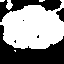

In [ ]:
# we can take the gray scale diff mask and post process it to get our binarized mask
binarized_mask = process_diffedit_mask(mask)
binarized_mask

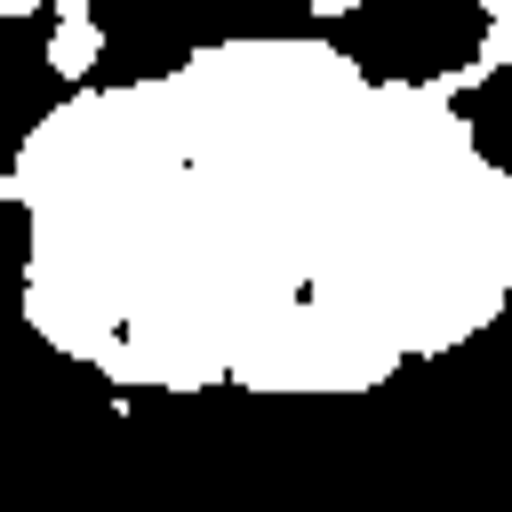

In [ ]:
# In order to use the mask for inpainting we need to scale it back up from 64x64 to image size 512x512
binarized_mask = binarized_mask.resize((512,512))
binarized_mask

seed: 16428495079677868580


  0%|          | 0/50 [00:00<?, ?it/s]

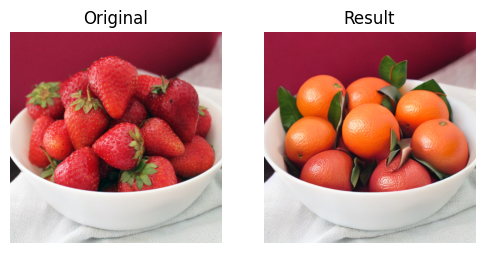

In [ ]:
# Now we'll use the mask to do a stable diffusion in painting operation using our target prompt

seed = 16428495079677868580
#seed = torch.seed()
print('seed:',seed)
generator = torch.Generator(torch_device).manual_seed(seed)
im_result = inpaint(prompt=['Bowl of Oranges'],image=im,mask_image=binarized_mask,generator=generator).images[0]
show_images([im,im_result],titles=['Original','Result'])

### Interactively Fune Tune our Mask by Changing the Binarization Threshold

Generating the difference is fairly expensive, since we have to run the Stable Diffusion process about 20 times to generate a good 'gray-scale difference' between the prompts.  Given this difference we can control the binarization separately by manipulating the threshold used as demonstrated here.

_The current default threshold of 0.35 was arrived at experimentally._

interactive(children=(FloatSlider(value=0.35, description='threshold', max=1.0, step=0.05), Output()), _dom_cl…

<function __main__.f(threshold)>

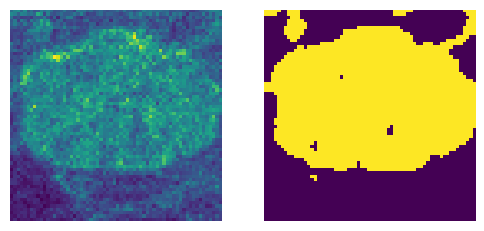

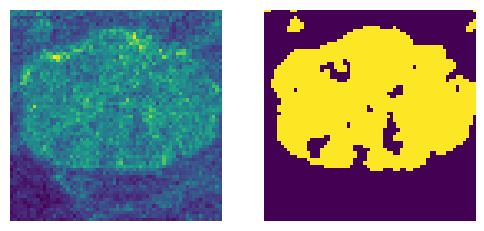

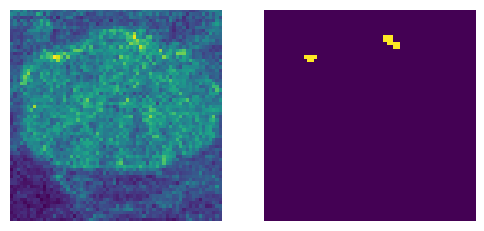

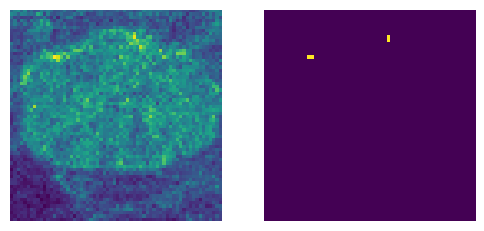

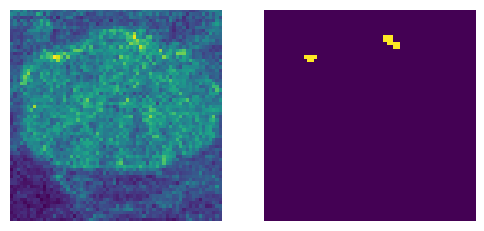

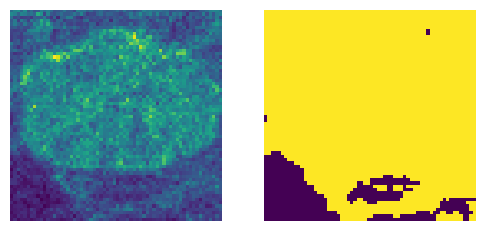

In [ ]:

from ipywidgets import interact,FloatSlider

def f(threshold):
    show_images([mask,process_diffedit_mask(mask,threshold)])
    return

interact(f,threshold=FloatSlider(min=0.,max=1.,value=0.35,step=0.05))

## Putting It All Together - Demonstrate DiffEdit in Action

### Using DiffEdit to Edit an Image of a "Bowl of Fruit"

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

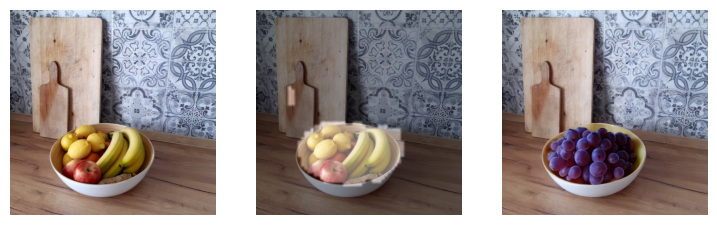

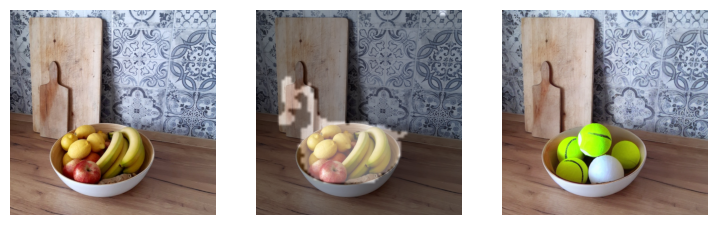

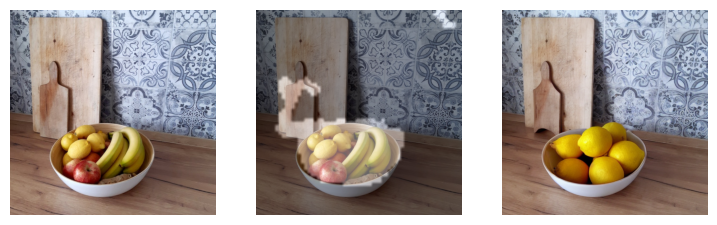

In [ ]:
prompts = [
('Bowl of Fruit','Bowl of Grapes'),
('Bowl of Fruit','Bowl of Tennis Balls'),
('Bowl of Fruit','Bowl of Lemons'),
]

seed=12835639026266870718
#seed=torch.seed()
print('seed:',seed)
im_path = FastDownload().download('https://raw.githubusercontent.com/johnrobinsn/diffusion_experiments/main/images/fruitbowl_scaled.jpg')
for p in prompts: demo_diffedit(im_path,*p,seed=seed)

### Using DiffEdit to Edit an Image of 'Mario"'

  0%|          | 0/50 [00:00<?, ?it/s]

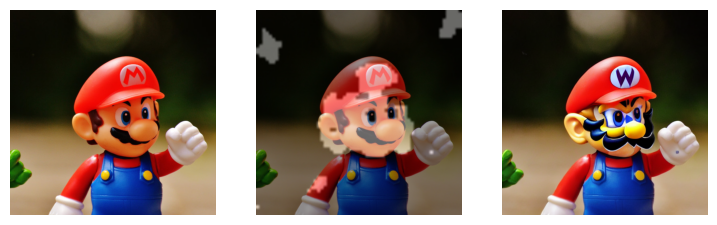

In [ ]:
prompts = [('Mario','Wario')]
seed = 10522222506065218495
#seed = torch.seed()
print('seed:',seed)
im_path = FastDownload().download('https://raw.githubusercontent.com/johnrobinsn/diffusion_experiments/main/images/mario_scaled.jpg')
for p in prompts: demo_diffedit(im_path,*p,seed=seed,threshold=0.35)

### Using DiffEdit to Edit an Image of a 'Horse'

seed: 3624651140942376049


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

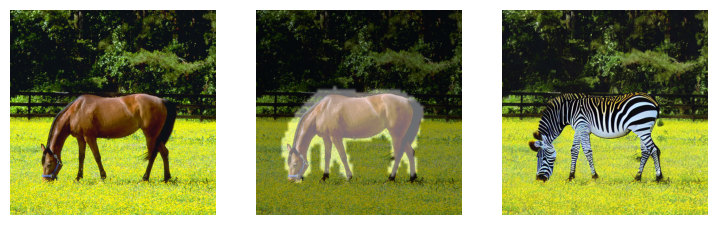

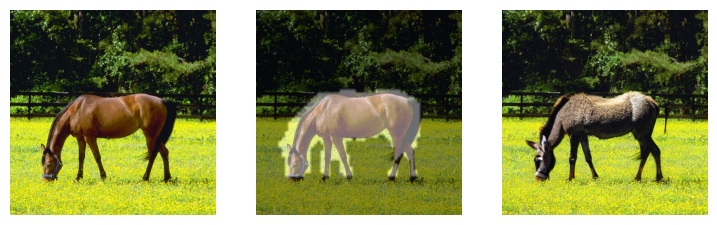

In [ ]:
prompts = [
    ('Horse','Zebra'),
    ('Horse','Donkey')
]

seed=3624651140942376049
#seed=torch.seed()
print('seed:',seed)
im_path = FastDownload().download('https://raw.githubusercontent.com/johnrobinsn/diffusion_experiments/main/images/horse_scaled.jpg')
for p in prompts: demo_diffedit(im_path,*p,seed=seed)

In [ ]:
# Show the original image, the original image with mask and the resulting inpainted image
def multiple_masks_diffedit(im_path,prompts,**kwargs):
    im_path = Path(im_path)
    out = []

    im = Image.open(im_path).resize((512,512))
    im_latent = image2latent(im)
    out.append(im)

    for prompt in prompts:
      ref_prompt, query_prompt = prompt
      if 'seed' not in kwargs: kwargs['seed'] = torch.seed()
      diff_mask = calc_diffedit_diff(im_latent,ref_prompt,query_prompt,**kwargs)
      out.append(diff_mask)
      mask = calc_diffedit_mask(im_latent,ref_prompt,query_prompt,**kwargs)
      out.append(mask)
      # out.append(get_blended_mask(im,mask))
      # out.append(inpaint(prompt=[query_prompt],image=im,mask_image=mask,
      #     generator=torch.Generator(torch_device).manual_seed(kwargs['seed'])).images[0])
      show_images(out)

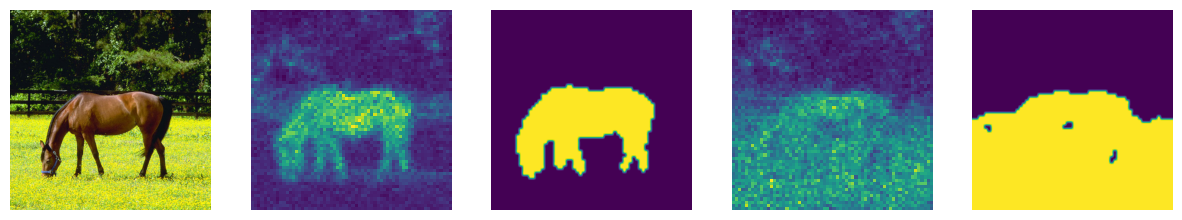

In [ ]:
prompts = [
    ('Horse','Zebra'),
    ('Grass','Sand')
]

seed=3624651140942376049
#seed=torch.seed()
print('seed:',seed)
im_path = FastDownload().download('https://raw.githubusercontent.com/johnrobinsn/diffusion_experiments/main/images/horse_scaled.jpg')
multiple_masks_diffedit(im_path,prompts,seed=seed)

In [ ]:
# prompt: generate function to process_diffedit_mask with more than one mask and prompt

import numpy as np
def process_diffedit_masks(masks, threshold=0.35, **kwargs):
    masks = []
    for mask in masks:
        mask = np.array(mask).astype(np.float32)
        mask = cv2.GaussianBlur(mask, (5, 5), 1)
        mask = (mask > (255. * threshold)).astype(np.float32) * 255
        mask = Image.fromarray(mask.astype(np.uint8))
        masks.append(mask)
    return masks
